# Обзор алгоритма

Self-organizing map (SOM) - это специальный тип нейронной сети с обучением без учителя, выполняющий задачу визуализации и кластеризации. Алгоритм по сути сжимает информацию, сохраняя при этом наиболее важные топологические и метрические взаимосвязи исходных данных.

**Архитектура сети:**\
Сеть состоит из двух слоев: входного и выходного (карты признаков).
Сначала выбирается количество нейронов и их координаты, а затем каждому нейрону назначается вектор весов с той же размерностью, что и входное пространство. При этом, в отличие от других типов нейронных сетей, в SOM нейроны не имеют функции активации, т.е. веса напрямую передаютя на выходной слой. Также в SOM используется конкурентное обучение для корректировки весов в нейронах, вместо метода обратного распространения ошибки.

**Входные данные:**\
*d* — размерность признакового пространства\
*n* — количество элементов в наборе данных\
*X(n·d)* — матрица с входными данными\

**Передаваемые гиперпараметры:**\
*m* — количество нейронов\
*T* — количество эпох\
**$\eta$** — скорость обучения (монотонно сходится к 0 по количеству эпох t)\
**$\sigma$** — коэффициент кооперации (монотонно убывает по t)\
**$\gamma$** — коэффициент затухания скорости обучения\
**$\alpha$** — коэффициент  затухания кооперации


\
**Алгоритм:**
1. Инициализируются веса W
2. Каждая эпоха состоит из следующих шагов:\
    • В случайном порядке перебираются элементы исходного датасета\
    • Для каждого выбранного элемента ищутся расстояния от него до векторов весов всех нейронов и определяется ближайший нейрон $M_{c}(t)$ - best matching unit(BMU) - в заданной метрике расстояния (например, евклидово или косинусное расстояние)\
    • Определяются коэффициенты близости $h_{jc}$ всех нейронов к $M_c(t)$\
    • Обновляются веса нейронов по формуле: $w_{j}(t + 1) = w_{j}(t) + \eta · h_{jc} · (x(t) - w_{j}(t))$\
    • Обновляются скорость обучения и коэффициент кооперации по формулам: $\eta = \eta · \gamma$ и $\sigma$ = $\sigma$ · $\alpha$\
    • Вычисляется ошибка карты (например как $\frac{1}{m}\sum _{i=1}^{m}\|x_{i}-w_{c}\|$)
    
   
**Вариации алгоритма**\
• Коэффициент соседства $h$ может задаваться разными способами. Чаще всего для этого используется гауссовская функция: $h_{jc}(t) = exp(-\frac{\|r_{c} - r_{j}\|^2}{2\sigma^2(t)})$, где $r_i$ - координаты нейрона $M_{i}$. Альтернативным вариантом является распределение Коши, при использовании которого больше нейронов будут изменяться на этапе кооперации.\
• Затухания $\gamma$ и $\alpha$ также чаще всего бывают экспоненциальными, однако можно использовать сигмоиду или гауссиану, которые увеличивают количество эпох до затухания.\
• Взаимное расположение нейронов можно подстраивать под данные.\
• SOM поддерживает обучение подвыборками
• Можно прекращать итерации, если значения W не будут меняться на протяжении нескольких эпох или ошибка карты будет незначительной.



**Существующие реализации**\
Наиболее популярные библиотеки с реализацией данного алгоритма: sklearn-som и som-learn. 


# Реализация алгоритмов

In [5]:
!pip install sklearn
!pip install pandas
!pip install sklearn_som
!pip install -U som-learn

In [6]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn_som.som import SOM

import somlearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Подготовка данных

In [7]:
df = pd.read_csv('menu.csv')

In [8]:
df['Serving Size'] = np.vectorize(lambda x: float(x.split(' ')[0]))(df['Serving Size'])

In [9]:
y = df['Category']
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [10]:
df = df.drop('Category', 1)
df = df.drop('Item', 1)

<ipython-input-10-336ef4a359b5>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Category', 1)
<ipython-input-10-336ef4a359b5>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Item', 1)


In [11]:
df

,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,Cholesterol,Cholesterol (% Daily Value),...,Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,4.8,300,120,13.0,20,5.0,25,0.0,260,87,...,31,10,4,17,3,17,10,0,25,15
1,4.8,250,70,8.0,12,3.0,15,0.0,25,8,...,30,10,4,17,3,18,6,0,25,8
2,3.9,370,200,23.0,35,8.0,42,0.0,45,15,...,29,10,4,17,2,14,8,0,25,10
3,5.7,450,250,28.0,43,10.0,52,0.0,285,95,...,30,10,4,17,2,21,15,0,30,15
4,5.7,400,210,23.0,35,8.0,42,0.0,50,16,...,30,10,4,17,2,21,6,0,25,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,10.1,510,150,17.0,26,9.0,44,0.5,45,14,...,80,27,1,4,64,12,15,0,40,8
256,13.4,690,200,23.0,35,12.0,58,1.0,55,19,...,106,35,1,5,85,15,20,0,50,10
257,6.7,340,100,11.0,17,6.0,29,0.0,30,9,...,53,18,1,2,43,8,10,0,25,6
258,14.2,810,290,32.0,50,15.0,76,1.0,60,20,...,114,38,2,9,103,21,20,0,60,6


In [12]:
num_of_clusters = pd.Series(y).unique().size

In [13]:
pairs_y = np.zeros(y.size * (y.size - 1) // 2) 
n = 0

for i in range(y.size):
    for j in range(i + 1, y.size):
        pairs_y[n] = (y[i] == y[j])
        n += 1

# Agglomerative Clustering

In [14]:
clustering = AgglomerativeClustering(num_of_clusters).fit(df)
pred = clustering.labels_

In [15]:
pairs_pred = np.zeros(y.size * (y.size - 1) // 2) 
n = 0

for i in range(y.size):
    for j in range(i + 1, y.size):
        pairs_pred[n] = (pred[i] == pred[j])
        n += 1

In [16]:
roc_auc_score(pairs_y, pairs_pred) 

0.616002078994827

In [17]:
accuracy_score(pairs_y, pairs_pred)

0.7586278586278586

# sklearn_som

In [42]:
som = SOM(m=3, n=3, dim=22)
som.fit(np.array(df))
pred = som.predict(np.array(df))

In [19]:
pairs_pred = np.zeros(y.size * (y.size - 1) // 2) 
n = 0

for i in range(y.size):
    for j in range(i + 1, y.size):
        pairs_pred[n] = (pred[i] == pred[j])
        n += 1

In [20]:
roc_auc_score(pairs_y, pairs_pred) 

0.6082358054535243

In [21]:
accuracy_score(pairs_y, pairs_pred)

0.7751707751707752

# som-learn

In [22]:
som = somlearn.SOM(n_columns=3, n_rows=3)
pred = som.fit_predict(np.array(df))

In [23]:
pairs_pred = np.zeros(y.size * (y.size - 1) // 2) 
n = 0

for i in range(y.size):
    for j in range(i + 1, y.size):
        pairs_pred[n] = (pred[i] == pred[j])
        n += 1

In [24]:
roc_auc_score(pairs_y, pairs_pred) 

0.5821035799872329

In [25]:
accuracy_score(pairs_y, pairs_pred)

0.7838134838134838

# ВИЗУАЛИЗАЦИЯ

In [26]:
!pip install seaborn

In [27]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from matplotlib import animation
from sklearn.decomposition import PCA
import seaborn as sns

In [28]:
pca = PCA(n_components = 2)
pca.fit(df) 

print(pca.explained_variance_ratio_)

[0.90928824 0.07127097]


In [30]:
pca_df = pd.DataFrame(pca.transform(df))

In [46]:
pca_df['SOM_2'] = pred
pca_df['Agglomerative Clustering'] = clustering.labels_
pca_df['real'] = y

<AxesSubplot:xlabel='0', ylabel='1'>

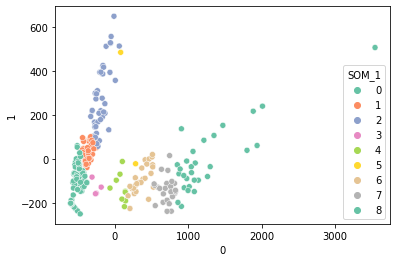

In [44]:
pca_df['SOM_1'] = pred
sns.scatterplot(x=pca_df[0], y=pca_df[1], hue=pca_df['SOM_1'], palette="Set2")

<AxesSubplot:xlabel='0', ylabel='1'>

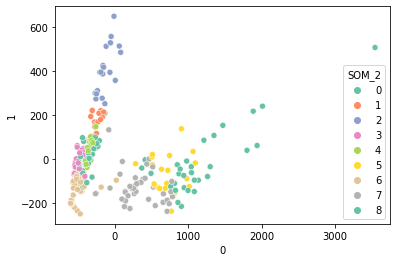

In [40]:
sns.scatterplot(x=pca_df[0], y=pca_df[1], hue=pca_df['SOM_2'], palette="Set2")

<AxesSubplot:xlabel='0', ylabel='1'>

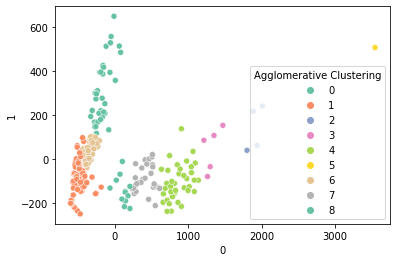

In [41]:
sns.scatterplot(x=pca_df[0], y=pca_df[1], hue=pca_df['Agglomerative Clustering'], 
                palette="Set2")

<AxesSubplot:xlabel='0', ylabel='1'>

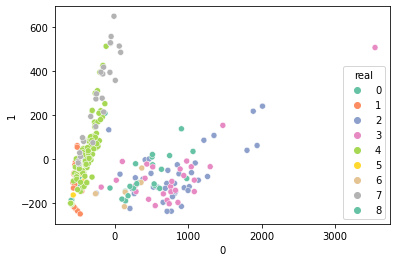

In [47]:
sns.scatterplot(x=pca_df[0], y=pca_df[1], hue=pca_df['real'], palette="Set2")